<a href="https://colab.research.google.com/github/Suryansh1089/Sarcasm-Detection/blob/main/SarcasmDetectionUsing_RNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
!pip install keras.utils


Processing /root/.cache/pip/wheels/46/25/27/7707005c1cb27e1ffc8277b004ac295e34767b02b44d73d6be/keras_utils-1.0.13-cp37-none-any.whl


In [10]:
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
%matplotlib inline
import os
import re


DATA PREPROCESSING

In [24]:
data=pd.read_json("twitter_train.jsonl",lines=True)

In [25]:
data.head()

,label,response,context
0,SARCASM,@USER @USER @USER I don't get this .. obviousl...,[A minor child deserves privacy and should be ...
1,SARCASM,@USER @USER trying to protest about . Talking ...,[@USER @USER Why is he a loser ? He's just a P...
2,SARCASM,@USER @USER @USER He makes an insane about of ...,[Donald J . Trump is guilty as charged . The e...
3,SARCASM,@USER @USER Meanwhile Trump won't even release...,[Jamie Raskin tanked Doug Collins . Collins lo...
4,SARCASM,@USER @USER Pretty Sure the Anti-Lincoln Crowd...,[Man ... y ’ all gone “ both sides ” the apoca...


In [26]:
def trans(x):
  if (x=='SARCASM'):
    return 1
  else: 
    return 0

In [27]:
data['label']=data['label'].apply(trans)

In [28]:
data.head()

,label,response,context
0,1,@USER @USER @USER I don't get this .. obviousl...,[A minor child deserves privacy and should be ...
1,1,@USER @USER trying to protest about . Talking ...,[@USER @USER Why is he a loser ? He's just a P...
2,1,@USER @USER @USER He makes an insane about of ...,[Donald J . Trump is guilty as charged . The e...
3,1,@USER @USER Meanwhile Trump won't even release...,[Jamie Raskin tanked Doug Collins . Collins lo...
4,1,@USER @USER Pretty Sure the Anti-Lincoln Crowd...,[Man ... y ’ all gone “ both sides ” the apoca...


In [29]:
data.tail()

,label,response,context
4995,0,@USER You don't . I have purchased a lot on Am...,[@USER Apologies for the inconvenience you fac...
4996,0,@USER #Emotions you say 🤔 never knew that I th...,"[@USER 🤔 idk tho , I think I ’ m #hungry . But..."
4997,0,"@USER @USER @USER You are so right ... "" Yes !...","[@USER @USER @USER Peace to you , and two coun..."
4998,0,@USER @USER @USER Another lazy delusional vote...,[Bernie Sanders told Elizabeth Warren in priva...
4999,0,@USER @USER I hope you know no news outlet fro...,[PDP PROTEST BRAINSTORMING SESSION Deji : We n...


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Sarcasm vs Non-sarcasm')

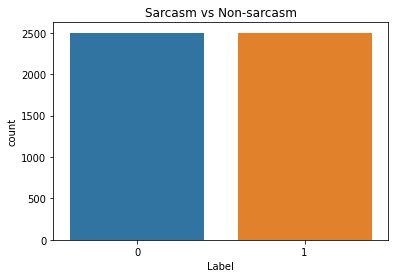

In [30]:
sns.countplot(data.label)
plt.xlabel('Label')
plt.title('Sarcasm vs Non-sarcasm')

In [31]:

def clean_text(text):
    text = text.lower()
    
    pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    text = pattern.sub('', text)
    text = " ".join(filter(lambda x:x[0]!='@', text.split()))
    emoji = re.compile("["
                           u"\U0001F600-\U0001FFFF"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    
    
    text = text.lower()
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"that's", "that is", text)        
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"where's", "where is", text) 
    text = re.sub(r"\'ll", " will", text)  
    text = re.sub(r"\'ve", " have", text)  
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"did't", "did not", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"have't", "have not", text)
    text = re.sub(r"[,.\"\'!@#$%^&*(){}?/;`~:<>+=-]", "", text)
    return text

In [32]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

def CleanTokenize(df):
    head_lines = list()
    lines = df["response"].values.tolist()

    for line in lines:
        line = clean_text(line)
        # tokenize the text
        tokens = word_tokenize(line)
        # remove puntuations
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in tokens]
        # remove non alphabetic characters
        words = [word for word in stripped if word.isalpha()]
        stop_words = set(stopwords.words("english"))
        # remove stop words
        words = [w for w in words if not w in stop_words]
        head_lines.append(words)
    return head_lines

head_lines = CleanTokenize(data)
head_lines[0:10]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[['get',
  'obviously',
  'care',
  'would',
  'moved',
  'right',
  'along',
  'instead',
  'decided',
  'care',
  'troll'],
 ['trying', 'protest', 'talking', 'labels', 'label', 'wtf', 'make', 'em'],
 ['makes', 'insane', 'money', 'movies', 'einstein', 'learnhowthesystemworks'],
 ['meanwhile',
  'trump',
  'even',
  'release',
  'sat',
  'scores',
  'wharton',
  'professors',
  'said',
  'dumbest',
  'student',
  'ever',
  'taught'],
 ['pretty',
  'sure',
  'antilincoln',
  'crowd',
  'claimed',
  'democracy',
  'ballot',
  'thought',
  'lincoln',
  'authoritarian',
  'gop',
  'partyoflincoln',
  'democrats'],
 ['per', 'tag', 'line', 'never', 'judge', 'book', 'cover'],
 ['excites', 'kill', 'millions'],
 ['oh',
  'look',
  'racist',
  'offering',
  'solidarity',
  'gullible',
  'idiot',
  'whining',
  'racists'],
 ['biggest', 'bullies'],
 ['responds',
  'facts',
  'tossing',
  'frantic',
  'insults',
  'accuses',
  'others',
  'triggered',
  'facts']]

(-0.5, 999.5, 499.5, -0.5)

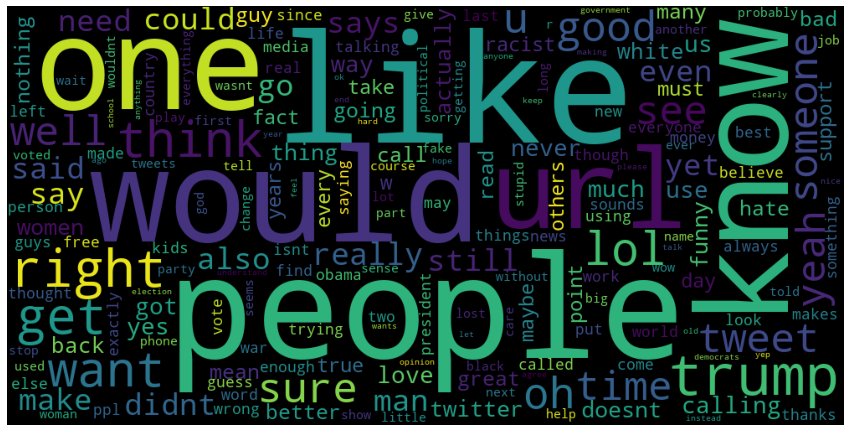

In [33]:
from collections import Counter
from wordcloud import WordCloud, ImageColorGenerator
pos_data = data.loc[data['label'] == 1]
pos_head_lines = CleanTokenize(pos_data)
pos_lines = [j for sub in pos_head_lines for j in sub] 
word_could_dict=Counter(pos_lines)

wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_could_dict)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")

In [62]:
validation_split = 0.2
max_length = 50
max_features=5000

tokenizer_obj = Tokenizer(num_words=max_features, split=' ')
tokenizer_obj.fit_on_texts(head_lines)
sequences = tokenizer_obj.texts_to_sequences(head_lines)

word_index = tokenizer_obj.word_index
print("unique tokens - ",len(word_index))
vocab_size = len(tokenizer_obj.word_index) + 1
print('vocab size -', vocab_size)

lines_pad = pad_sequences(sequences, maxlen=max_length, padding='post')
sentiment =  pd.get_dummies(data['label']).values

indices = np.arange(lines_pad.shape[0])
np.random.shuffle(indices)
lines_pad = lines_pad[indices]
sentiment = sentiment[indices]

num_validation_samples = int(validation_split * lines_pad.shape[0])

X_train_pad = lines_pad[:-num_validation_samples]
y_train = sentiment[:-num_validation_samples]
X_test_pad = lines_pad[-num_validation_samples:]
y_test = sentiment[-num_validation_samples:]

unique tokens -  12451
vocab size - 12452


In [63]:
print('Shape of X_train_pad:', X_train_pad.shape)
print('Shape of y_train:', y_train.shape)

print('Shape of X_test_pad:', X_test_pad.shape)
print('Shape of y_test:', y_test.shape)

Shape of X_train_pad: (4000, 50)
Shape of y_train: (4000, 2)
Shape of X_test_pad: (1000, 50)
Shape of y_test: (1000, 2)


DEFINING RNN LSTM MODEL

In [64]:
embed_dim = 256
lstm_out = 196

model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length = X_train_pad.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

In [65]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 256)           1280000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 50, 256)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 196)               355152    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 394       
Total params: 1,635,546
Trainable params: 1,635,546
Non-trainable params: 0
_________________________________________________________________


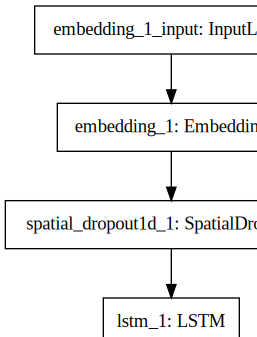

In [66]:
!pip install IPython
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [87]:
batch_size =32
history = model.fit(X_train_pad, y_train,
                    epochs = 30, batch_size=32,
                    validation_data=(X_test_pad,y_test),verbose=2)

Epoch 1/30
125/125 - 41s - loss: 0.6935 - accuracy: 0.4985 - val_loss: 0.6930 - val_accuracy: 0.5070
Epoch 2/30
125/125 - 41s - loss: 0.6937 - accuracy: 0.4910 - val_loss: 0.6931 - val_accuracy: 0.5070
Epoch 3/30
125/125 - 41s - loss: 0.6935 - accuracy: 0.4935 - val_loss: 0.6932 - val_accuracy: 0.4930
Epoch 4/30
125/125 - 40s - loss: 0.6937 - accuracy: 0.4895 - val_loss: 0.6936 - val_accuracy: 0.4930
Epoch 5/30
125/125 - 40s - loss: 0.6934 - accuracy: 0.4955 - val_loss: 0.6932 - val_accuracy: 0.4930
Epoch 6/30
125/125 - 40s - loss: 0.6934 - accuracy: 0.4995 - val_loss: 0.6931 - val_accuracy: 0.5070
Epoch 7/30
125/125 - 40s - loss: 0.6933 - accuracy: 0.4975 - val_loss: 0.6939 - val_accuracy: 0.4930
Epoch 8/30
125/125 - 40s - loss: 0.6935 - accuracy: 0.5040 - val_loss: 0.6933 - val_accuracy: 0.4930
Epoch 9/30
125/125 - 40s - loss: 0.6935 - accuracy: 0.4850 - val_loss: 0.6931 - val_accuracy: 0.5070
Epoch 10/30
125/125 - 40s - loss: 0.6916 - accuracy: 0.5132 - val_loss: 0.7019 - val_accura

In [88]:
X_train_pad.shape

(4000, 50)

In [89]:
y_train.shape

(4000, 2)

In [90]:
score,acc = model.evaluate(X_test_pad, y_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

32/32 - 1s - loss: 0.6898 - accuracy: 0.5070
score: 0.69
acc: 0.51


GRAPH FOR ACCURACY,LOSS AND EPOCH

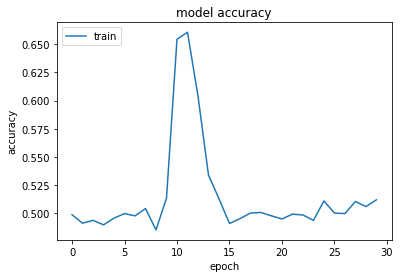

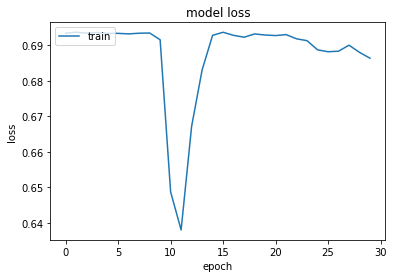

<Figure size 432x288 with 0 Axes>

In [91]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model_accuracy.png')
# summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model_loss.png')

The graph indicates we must stop our epoch at around 15

TEST EXAMPLE

In [96]:
headline = ['HE TROLLED ME SO NICE OF HIM']
headline = tokenizer_obj.texts_to_sequences(headline)
headline = pad_sequences(headline, maxlen=29, dtype='int32', value=0)

sentiment = model.predict(headline,batch_size=1,verbose = 2)[0]
if(np.argmax(sentiment) == 0):
    print("Non-sarcastic")
elif (np.argmax(sentiment) == 1):
    print("Sarcasm")


1/1 - 0s
Sarcasm


VISUALIZE THE LEARNING

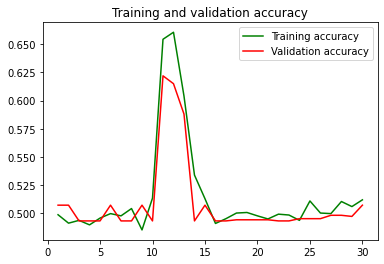

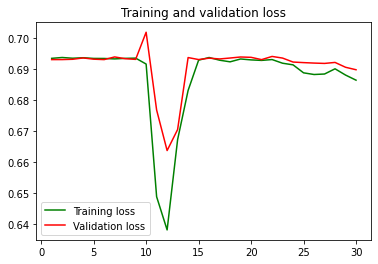

In [99]:
# Plot results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()